In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import utils
import sys

plt.style.use('seaborn-v0_8-whitegrid')

### 2.2

  0%|          | 0/5 [00:00<?, ?it/s]

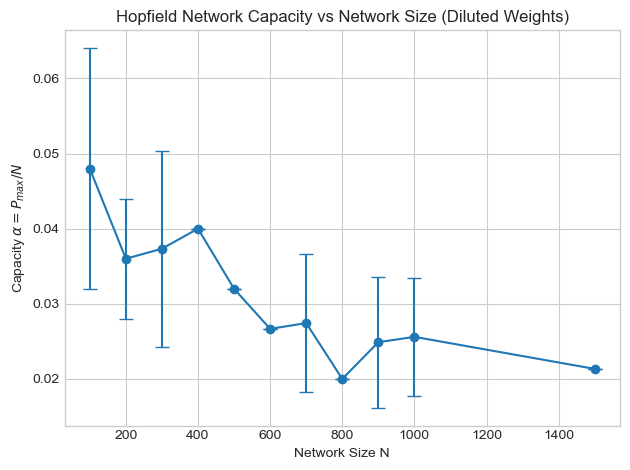

In [2]:
THRESHOLD =  1#[1e-2, 1e-3, 1e-5, 1e-6]
NETWORK_DIM = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500]
N_TRIALS = 5

plt.figure()

all_p_maxs = np.zeros((N_TRIALS, len(NETWORK_DIM)), dtype=int)

for trial in tqdm(range(N_TRIALS)):
    for idx, dim in enumerate(NETWORK_DIM):
        P = 1
        while True:
            patterns = utils.get_n_binary_patterns(n_patterns=P, pattern_dim=dim)
            weights = utils.get_weights(patterns, diluted=True)
            success = True
            for p in patterns:
                ns = utils.compute_next_state(p, weights)
                if utils.overlap(p, ns) < THRESHOLD:
                    success = False
                    break
            if not success:
                break
            P *= 2

        low = P // 2
        p_max = low
        for P_lin in range(low + 1, P):
            patterns = utils.get_n_binary_patterns(n_patterns=P_lin, pattern_dim=dim)
            weights = utils.get_weights(patterns, diluted=True)
            success = True
            for p in patterns:
                ns = utils.compute_next_state(p, weights)
                if utils.overlap(p, ns) <= THRESHOLD:
                    success = False
                    break
            if not success:
                p_max = P_lin - 1
                break
            else:
                p_max = P_lin
            tqdm.write(f"\rTrial {trial+1}, N={dim}, Threshold={THRESHOLD}: curr P_max={p_max}", end='       ')
            sys.stdout.flush()
        all_p_maxs[trial, idx] = p_max
    # tqdm.write("\rDone", end='                                                                  ')
    # sys.stdout.flush()
mean_p_maxs = all_p_maxs.mean(axis=0)
stderr_p_maxs = all_p_maxs.std(axis=0)
theoretical_alpha = mean_p_maxs / np.array(NETWORK_DIM)

plt.errorbar(NETWORK_DIM, theoretical_alpha, yerr=stderr_p_maxs / np.array(NETWORK_DIM),
             fmt='o-', capsize=5, label=f'Threshold = {THRESHOLD}')

plt.xlabel('Network Size N')
plt.ylabel(r'Capacity $\alpha = P_{max}/N$')
plt.title('Hopfield Network Capacity vs Network Size (Diluted Weights)')
# plt.legend()
plt.tight_layout()
plt.show()


### 2.3

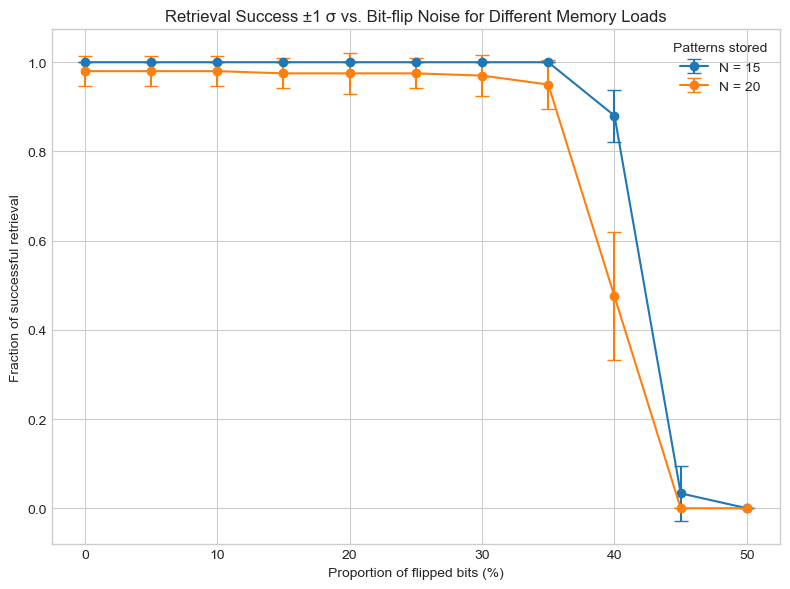

In [3]:
NETWORK_DIM   = 600
N_PATTERNS    = [15, 20]
T             = 5
N_FLIPS       = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300]
N_TRIALS      = 10       # number of repetitions per setting
THRESHOLD     = 1e-3    # for successful retrieval

plt.figure(figsize=(8,6))

for n_patterns in N_PATTERNS:
    # array to hold shape (n_trials, n_flips)
    all_fracs = np.zeros((N_TRIALS, len(N_FLIPS)))
    
    for trial in range(N_TRIALS):
        # draw a fresh set of patterns once per trial
        patterns = utils.get_n_binary_patterns(n_patterns=n_patterns,
                                               pattern_dim=NETWORK_DIM)
        weights = utils.get_weights(patterns, diluted=True)
        fracs = []
        for n_flip in N_FLIPS:
            success = []
            for init in patterns:
                cs = init.copy()
                # flip bits
                idx = np.random.choice(NETWORK_DIM, n_flip, replace=False)
                cs[idx] = -cs[idx]
                
                # run dynamics
                for _ in range(T):
                    cs = utils.compute_next_state(cs, weights)
                
                # check overlap
                success.append(np.abs(utils.overlap(init, cs) - 1) < THRESHOLD)
            
            fracs.append(np.mean(success))
        
        all_fracs[trial] = fracs
    
    # compute mean & std across trials
    mean_fracs = all_fracs.mean(axis=0)
    std_fracs  = all_fracs.std(axis=0)
    
    flip_proportion = (np.array(N_FLIPS) / NETWORK_DIM * 100).astype(int)
    plt.errorbar(flip_proportion, mean_fracs, yerr=std_fracs,
                 label=f'N = {n_patterns}', fmt='o-', capsize=5)

plt.xlabel('Proportion of flipped bits (%)')
plt.ylabel('Fraction of successful retrieval')
plt.title('Retrieval Success ±1 σ vs. Bit-flip Noise for Different Memory Loads')


plt.legend(title="Patterns stored")
plt.tight_layout()
plt.show()
